# Importing modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# Defining dataset

In [3]:
eeg_data = pd.read_csv('EEG_data.csv')
eeg_data_info = pd.read_csv('demographic_info.csv')

In [4]:
eeg_data.shape

(12811, 15)

In [5]:
eeg_data.head()

SubjectID  VideoID  Attention  Mediation    Raw      Delta     Theta  \
0        0.0      0.0       56.0       43.0  278.0   301963.0   90612.0   
1        0.0      0.0       40.0       35.0  -50.0    73787.0   28083.0   
2        0.0      0.0       47.0       48.0  101.0   758353.0  383745.0   
3        0.0      0.0       47.0       57.0   -5.0  2012240.0  129350.0   
4        0.0      0.0       44.0       53.0   -8.0  1005145.0  354328.0   

     Alpha1   Alpha2    Beta1     Beta2   Gamma1   Gamma2  predefinedlabel  \
0   33735.0  23991.0  27946.0   45097.0  33228.0   8293.0              0.0   
1    1439.0   2240.0   2746.0    3687.0   5293.0   2740.0              0.0   
2  201999.0  62107.0  36293.0  130536.0  57243.0  25354.0              0.0   
3   61236.0  17084.0  11488.0   62462.0  49960.0  33932.0              0.0   
4   37102.0  88881.0  45307.0   99603.0  44790.0  29749.0              0.0   

   user-definedlabeln  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0

# Data preprocessing

In [6]:
eeg_data_info

subject ID   age    ethnicity  gender
0           0    25  Han Chinese       M
1           1    24  Han Chinese       M
2           2    31      English       M
3           3    28  Han Chinese       F
4           4    24      Bengali       M
5           5    24  Han Chinese       M
6           6    24  Han Chinese       M
7           7    25  Han Chinese       M
8           8    25  Han Chinese       M
9           9    24  Han Chinese       F

In [7]:
#  Rename column subjectID
eeg_data_info.rename(columns={'subject ID':'SubjectID'}, inplace=True)

In [9]:

eeg_data['Sample'] = eeg_data.reset_index().index +0.5


In [10]:
# Merge the DataFrames on the appropriate columns
eeg_data_info = eeg_data_info.merge(eeg_data, left_on='SubjectID', right_on='SubjectID')


In [11]:
print(eeg_data_info.columns)

Index(['SubjectID', ' age', ' ethnicity', ' gender', 'VideoID', 'Attention',
       'Mediation', 'Raw', 'Delta', 'Theta', 'Alpha1', 'Alpha2', 'Beta1',
       'Beta2', 'Gamma1', 'Gamma2', 'predefinedlabel', 'user-definedlabeln',
       'Sample'],
      dtype='object')


In [12]:
eeg_data_info.head()

SubjectID   age    ethnicity  gender  VideoID  Attention  Mediation    Raw  \
0          0    25  Han Chinese       M      0.0       56.0       43.0  278.0   
1          0    25  Han Chinese       M      0.0       40.0       35.0  -50.0   
2          0    25  Han Chinese       M      0.0       47.0       48.0  101.0   
3          0    25  Han Chinese       M      0.0       47.0       57.0   -5.0   
4          0    25  Han Chinese       M      0.0       44.0       53.0   -8.0   

       Delta     Theta    Alpha1   Alpha2    Beta1     Beta2   Gamma1  \
0   301963.0   90612.0   33735.0  23991.0  27946.0   45097.0  33228.0   
1    73787.0   28083.0    1439.0   2240.0   2746.0    3687.0   5293.0   
2   758353.0  383745.0  201999.0  62107.0  36293.0  130536.0  57243.0   
3  2012240.0  129350.0   61236.0  17084.0  11488.0   62462.0  49960.0   
4  1005145.0  354328.0   37102.0  88881.0  45307.0   99603.0  44790.0   

    Gamma2  predefinedlabel  user-definedlabeln  Sample  
0   8293.0              0.0                 0.0     0.5  
1   2740.0              0.0                 0.0     1.5  
2  25354.0              0.0                 0.0     2.5  
3  33932.0              0.0                 0.0     3.5  
4  29749.0              0.0                 0.0     4.5

In [13]:
eeg_data_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12811 entries, 0 to 12810
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SubjectID           12811 non-null  int64  
 1    age                12811 non-null  int64  
 2    ethnicity          12811 non-null  object 
 3    gender             12811 non-null  object 
 4   VideoID             12811 non-null  float64
 5   Attention           12811 non-null  float64
 6   Mediation           12811 non-null  float64
 7   Raw                 12811 non-null  float64
 8   Delta               12811 non-null  float64
 9   Theta               12811 non-null  float64
 10  Alpha1              12811 non-null  float64
 11  Alpha2              12811 non-null  float64
 12  Beta1               12811 non-null  float64
 13  Beta2               12811 non-null  float64
 14  Gamma1              12811 non-null  float64
 15  Gamma2              12811 non-null  float64
 16  pred

In [14]:
eeg_data_info.rename(columns={' gender':'Gender'}, inplace=True)
eeg_data_info.rename(columns={' age':'Age'}, inplace=True)
eeg_data_info.rename(columns={' ethnicity':'Ethnicity'}, inplace=True)

In [15]:
#  change categorical data to numerical data
eeg_data_info['Gender'] = eeg_data_info['Gender'].replace({'M':1, 'F':0})
eeg_data_info['Ethnicity']=eeg_data_info['Ethnicity'].replace({'Han Chinese':0,'Bengali':1,'English':2})

## Exploratory data analysis (EDA)

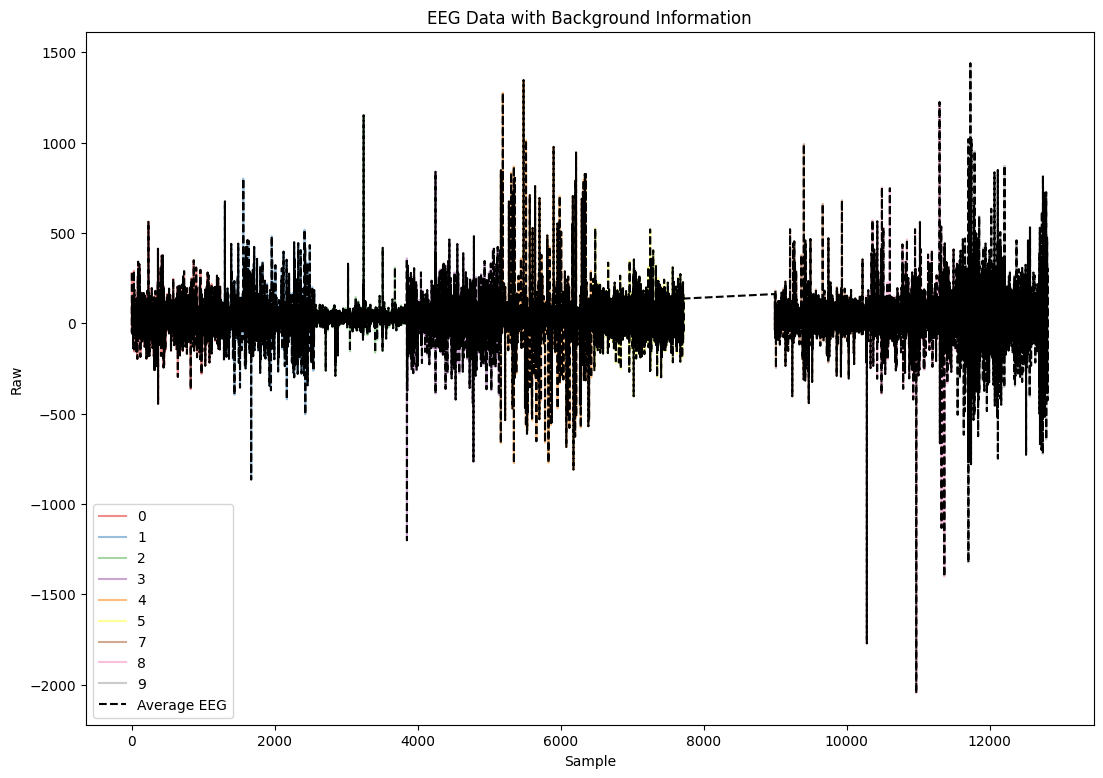

In [60]:
# Plot EEG data with background information
plt.figure(figsize=(13, 9))

# Plot EEG data
sns.lineplot(data=eeg_data_info, x='Sample', y='Raw', hue='SubjectID', palette='Set1', alpha=0.5)

# Add background data
# For example, add average EEG data
avg_raw = eeg_data_info.groupby('Sample')['Raw'].mean().reset_index()
plt.plot(avg_raw['Sample'], avg_raw['Raw'], linestyle='--', color='black', label='Average EEG')

# Add titles, labels, and legend
plt.xlabel('Sample')
plt.ylabel('Raw')
plt.title('EEG Data with Background Information')
plt.legend()

plt.show()

<ipython-input-64-c6d1909cd053>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=eeg_data_info, x='SubjectID', y='Raw', palette='Set1')


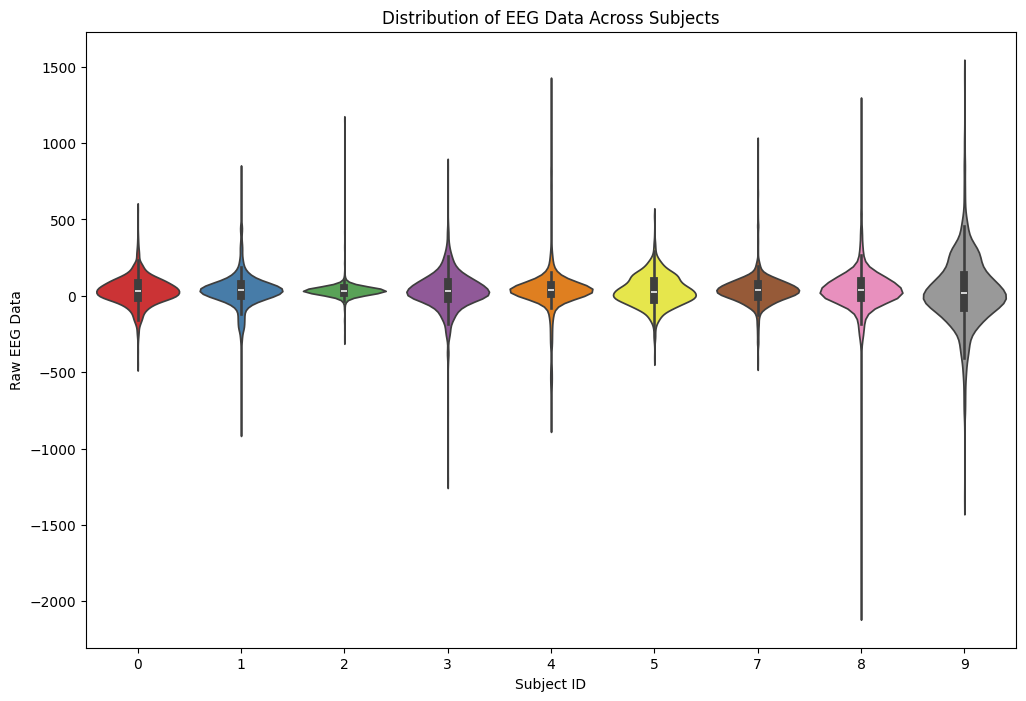

In [64]:
# Violin plot for EEG data distribution
plt.figure(figsize=(12, 8))

# Plot the violin plot
sns.violinplot(data=eeg_data_info, x='SubjectID', y='Raw', palette='Set1')

# Add titles and labels
plt.xlabel('Subject ID')
plt.ylabel('Raw EEG Data')
plt.title('Distribution of EEG Data Across Subjects')

plt.show()

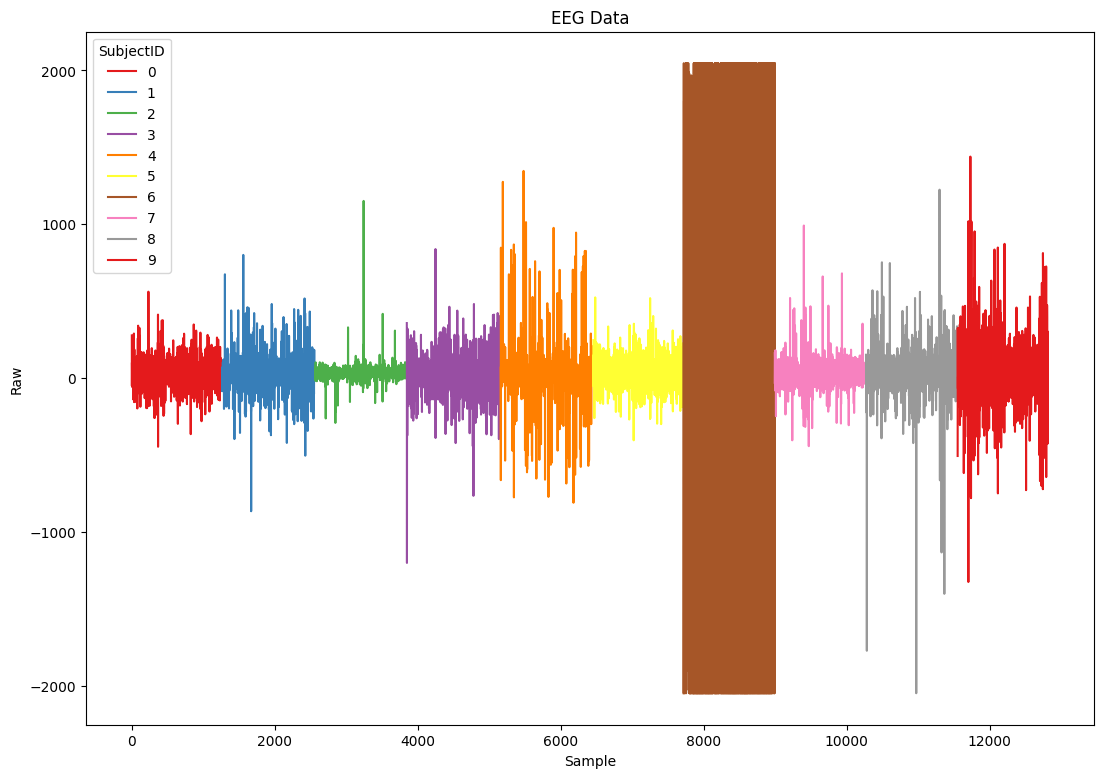

In [22]:
plt.figure(figsize=(13, 9))


sns.lineplot(data= eeg_data_info, x='Sample', y='Raw', hue='SubjectID', palette='Set1')

plt.xlabel('Sample')
plt.ylabel('Raw')
plt.title('EEG Data')

plt.show()

In [24]:
# Filter out rows where SubjectID is 6
eeg_data_info = eeg_data_info[eeg_data_info['SubjectID'] != 6]

# If you want to reset the index after filtering
eeg_data_info.reset_index(drop=True, inplace=True)

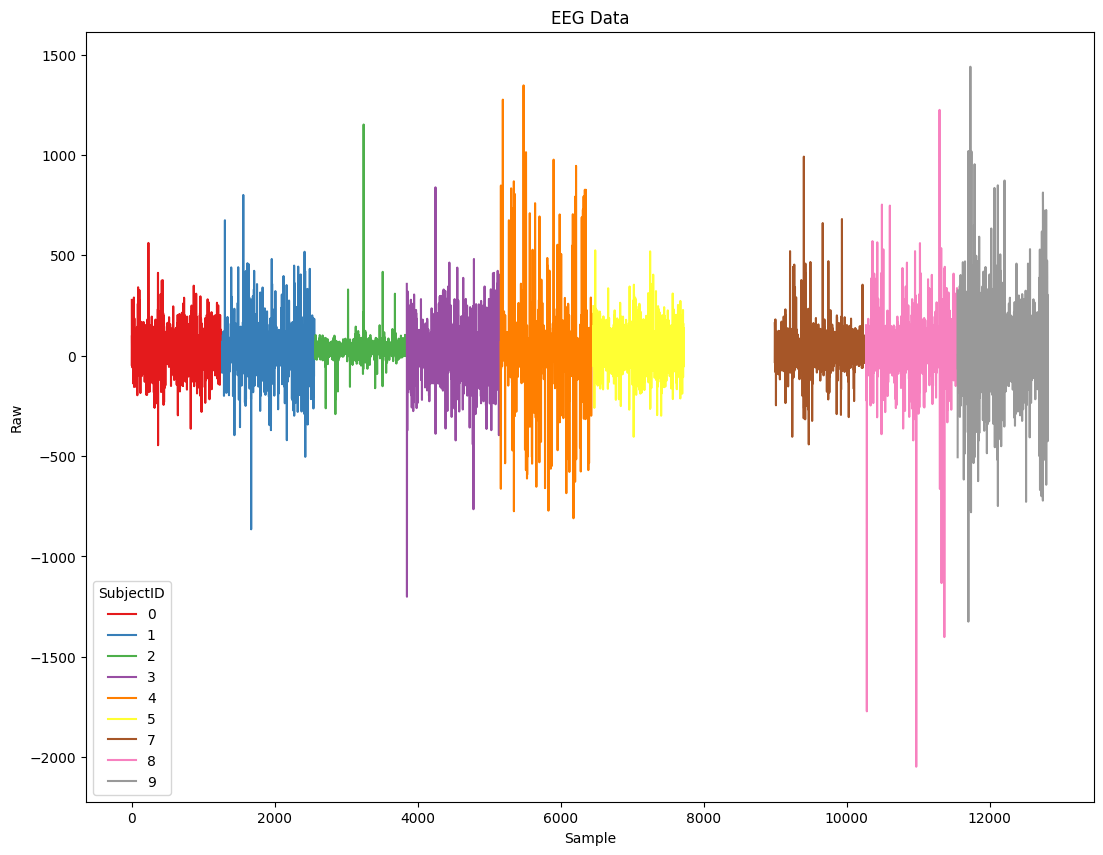

In [26]:
plt.figure(figsize=(13, 10))


sns.lineplot(data= eeg_data_info, x='Sample', y='Raw', hue='SubjectID', palette='Set1')

plt.xlabel('Sample')
plt.ylabel('Raw')
plt.title('EEG Data')

plt.show()  # Display the plot

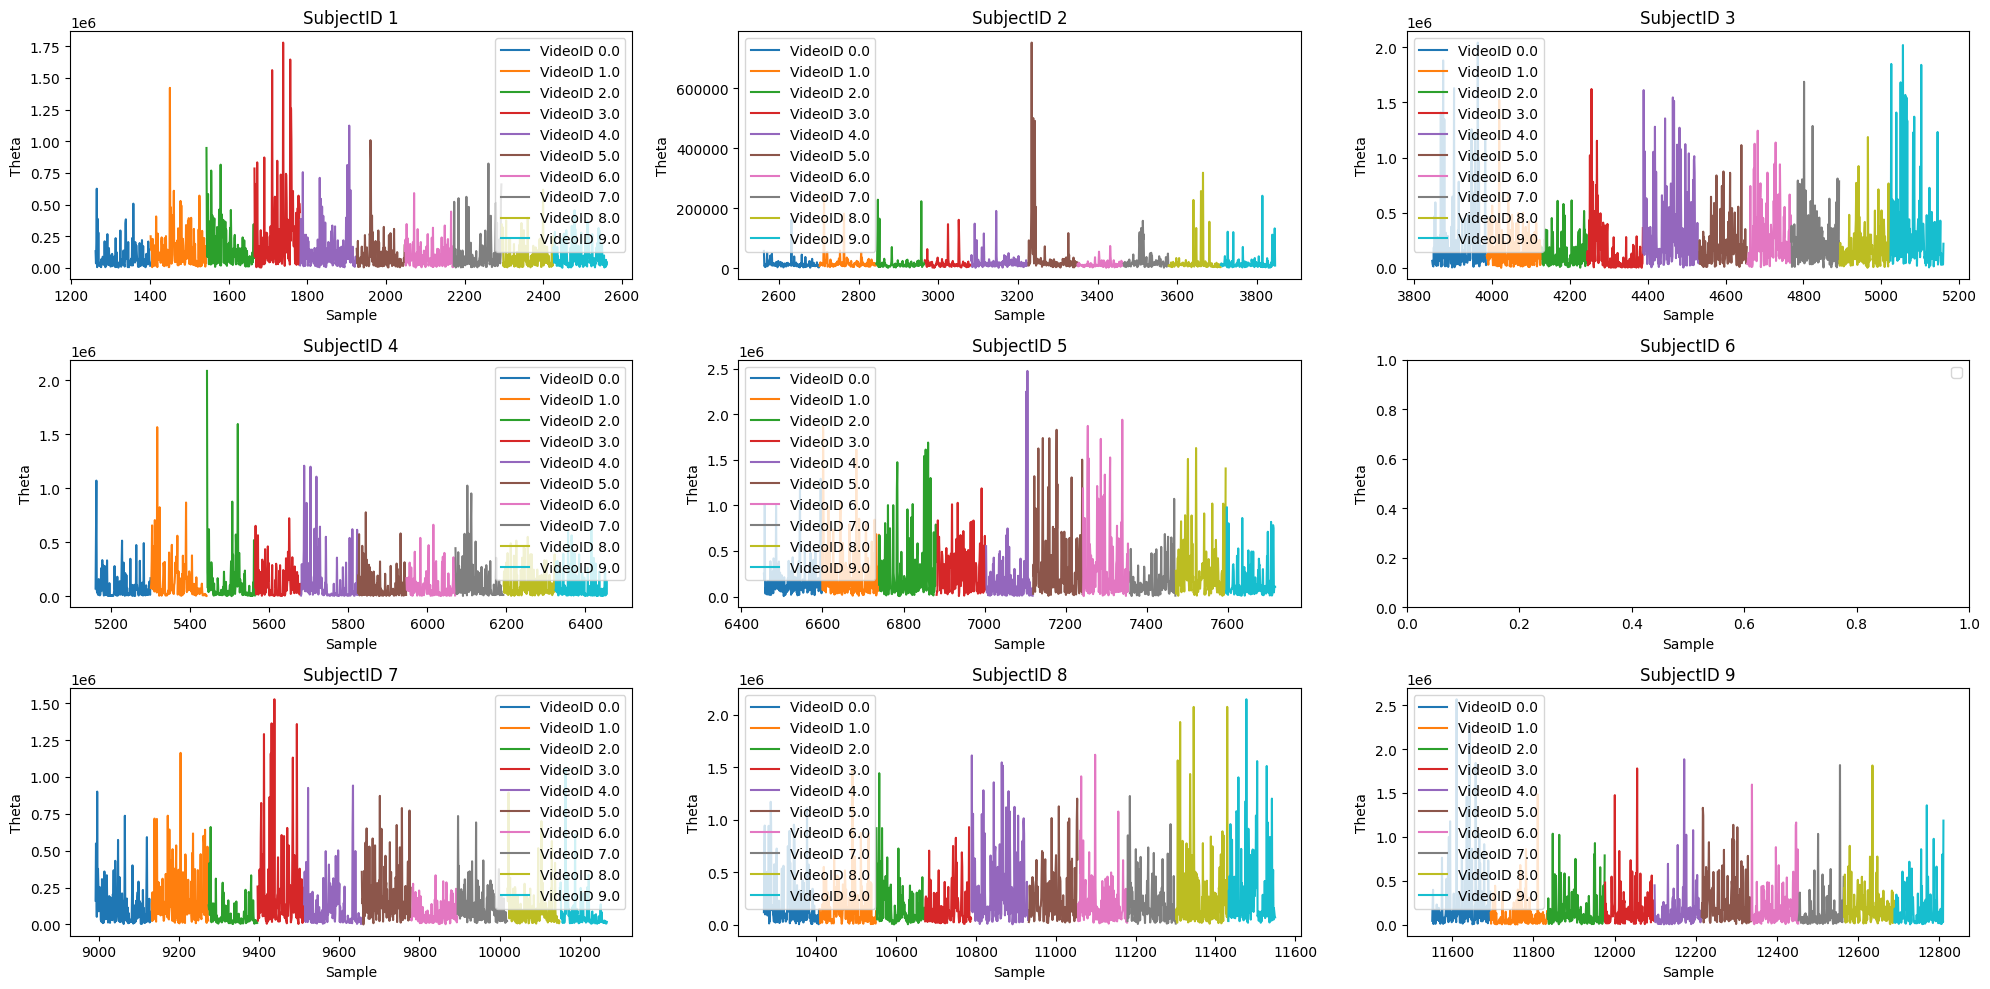

In [27]:
# Filter the DataFrame for subjects 1-9
filtered_df = eeg_data_info[eeg_data_info['SubjectID'].between(0, 10)]

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))

# Iterate over subjects and plot each VideoID subplot
for i, ax in enumerate(axes.flatten()):
    subject_data = filtered_df[filtered_df['SubjectID'] == i+1]
    for video_id, group_data in subject_data.groupby('VideoID'):
        ax.plot(group_data['Sample'], group_data['Theta'], label=f'VideoID {video_id}')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Theta')
    ax.set_title(f'SubjectID {i+1}')
    ax.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

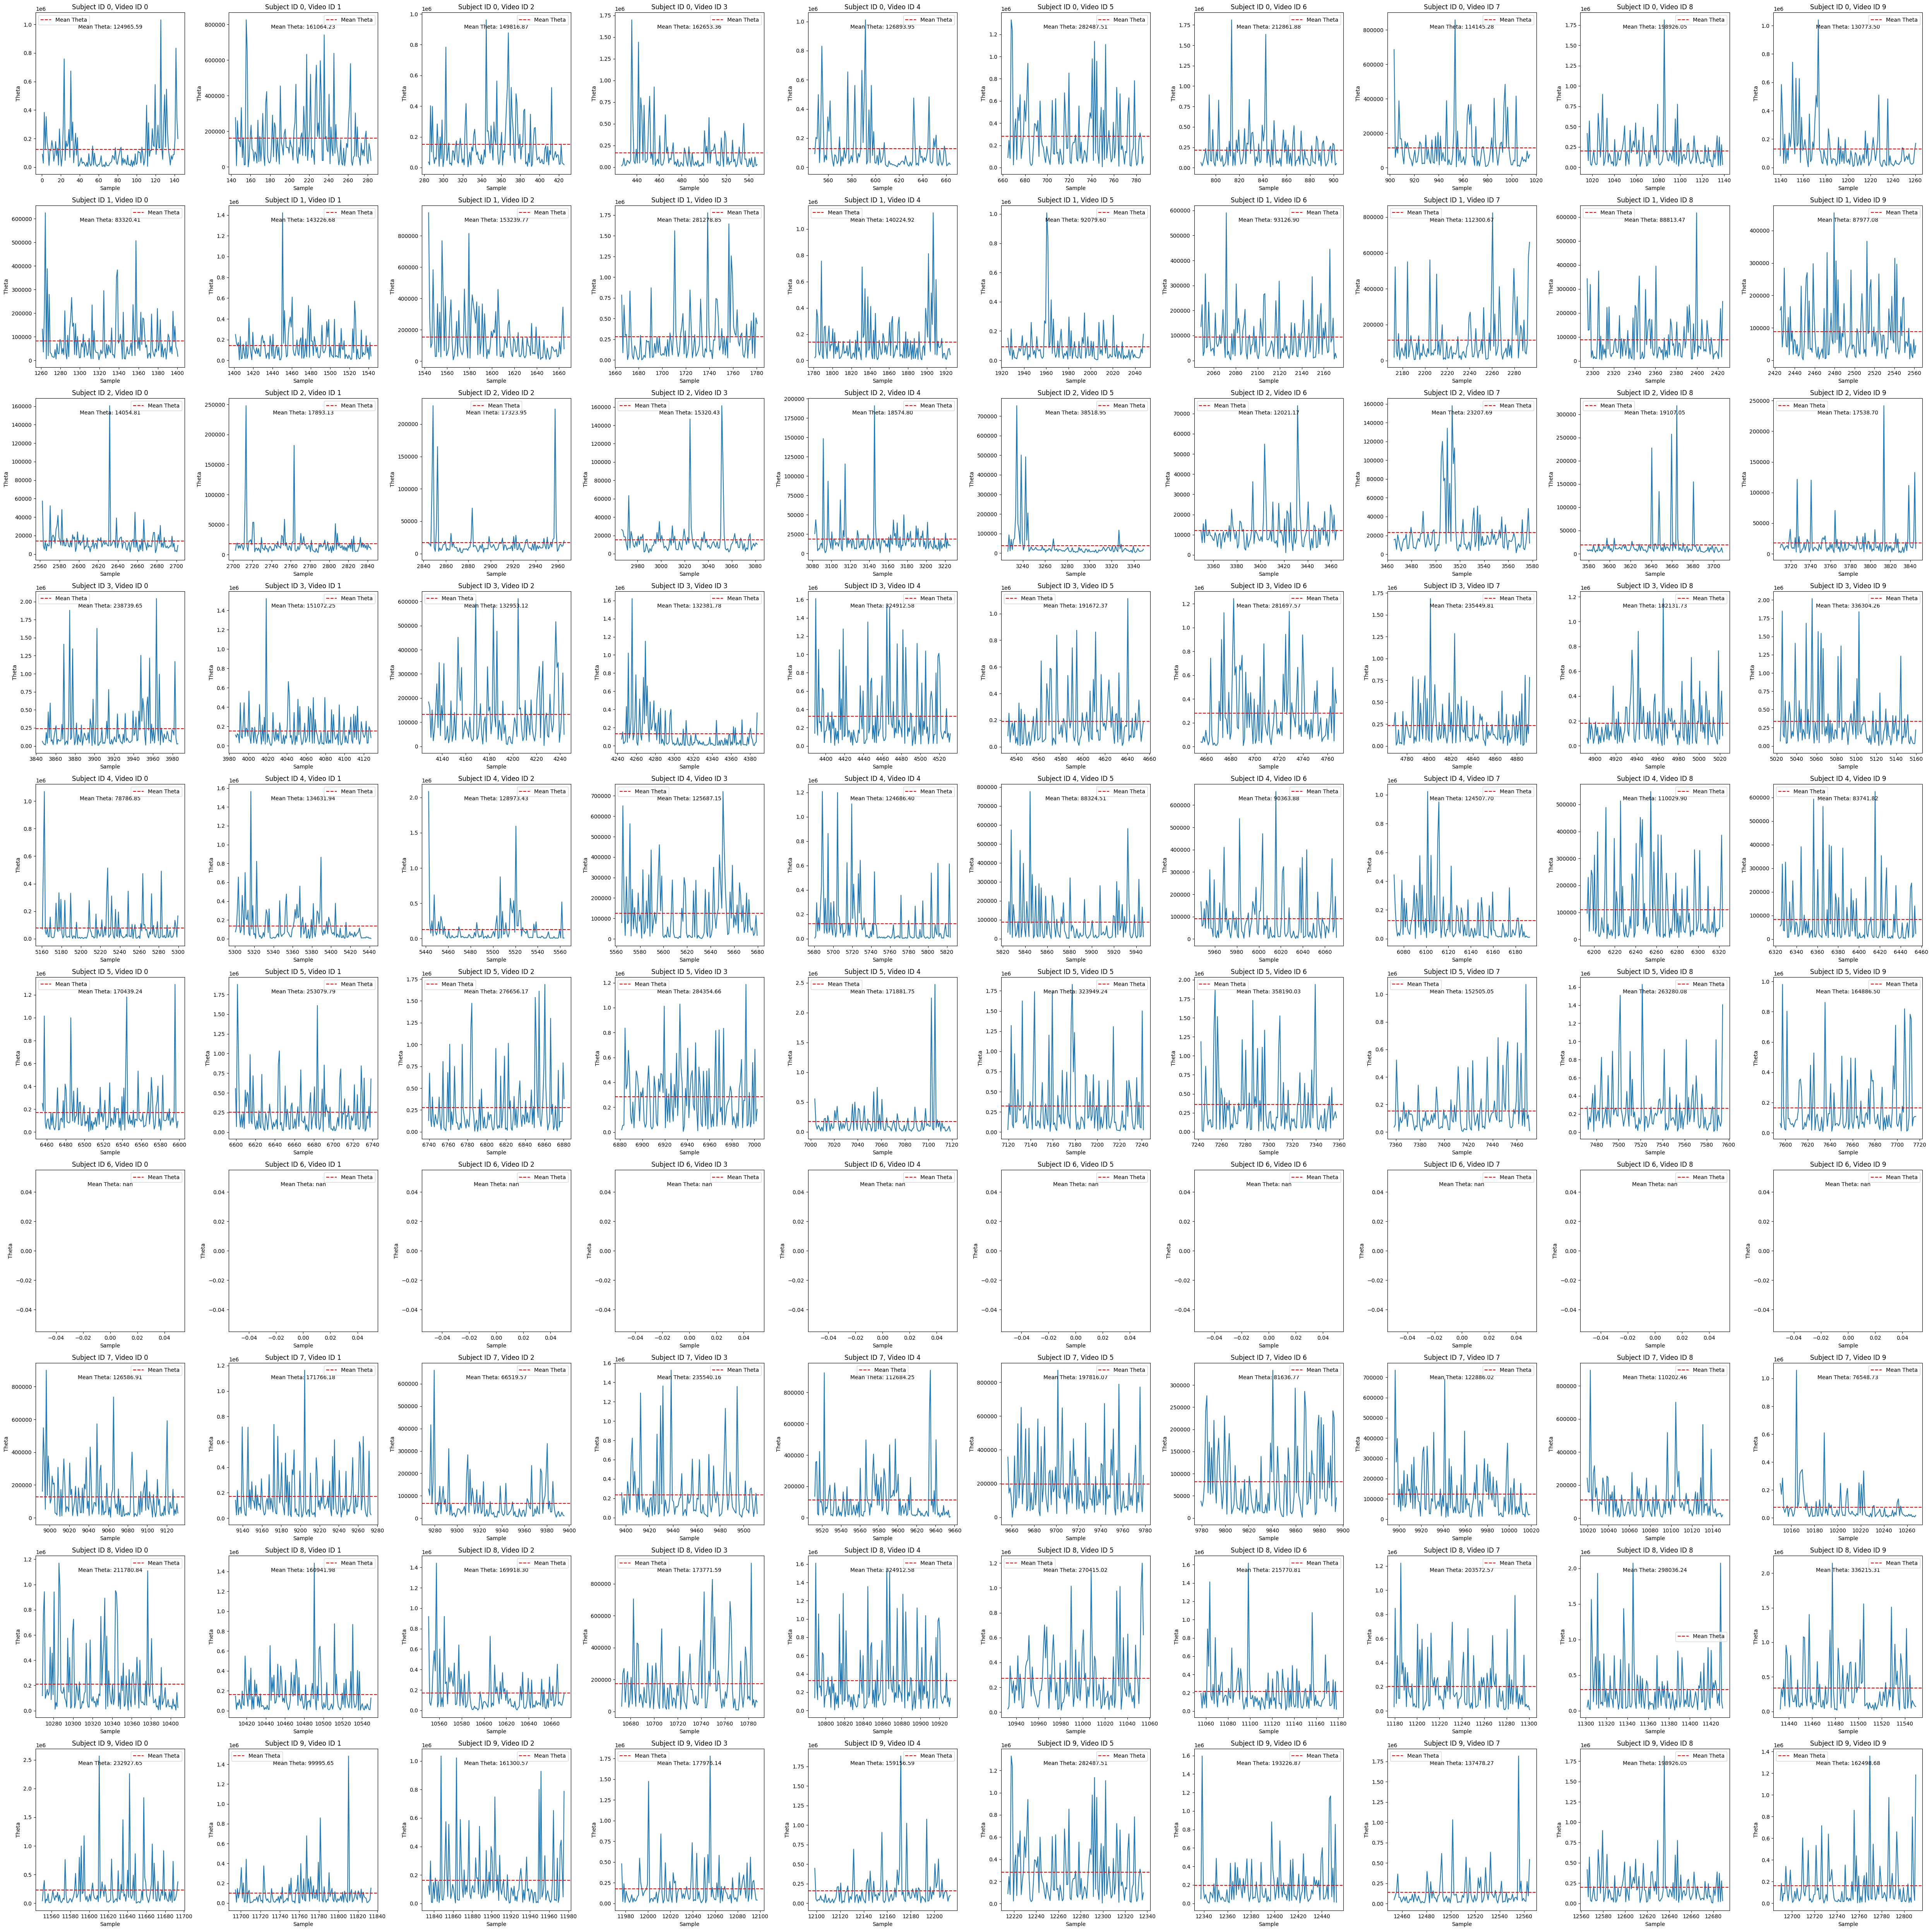

In [28]:
# Set the figure size and create subplots
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(50, 50))

# Iterate through subject IDs and video IDs to plot each subplot
for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        subject_id = i + 0  # Calculate subject ID based on subplot row
        video_id = j + 0 # Calculate video ID based on subplot column
        subset_df = eeg_data_info[(eeg_data_info['SubjectID'] == subject_id) & (eeg_data_info['VideoID'] == video_id)]
        sns.lineplot(data=subset_df, x='Sample', y='Theta', ax=ax)
        ax.set_title(f'Subject ID {subject_id}, Video ID {video_id}')
        ax.set_xlabel('Sample')
        ax.set_ylabel('Theta')
        # Calculate and display the mean of Theta on the plot
        mean_theta = subset_df['Theta'].mean()
        ax.axhline(mean_theta, color='red', linestyle='--', label='Mean Theta')
        ax.legend()
        ax.text(0.5, 0.9, f'Mean Theta: {mean_theta:.2f}', transform=ax.transAxes, ha='center')
# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## MOST CONFUSED STUDENT AND CAN BE SYNONYMOUS TO THE LESS INTELLIGENT OF THE STUDENTS

In [29]:
# Iterate through subject IDs and calculate the mean Theta for each subject
mean_theta_list = []
for subject_id in eeg_data_info['SubjectID'].unique():
    subset_df = eeg_data_info[eeg_data_info['SubjectID'] == subject_id]
    mean_theta = subset_df['Theta'].mean()
    mean_theta_list.append((subject_id, mean_theta))

# Sort the mean_theta_list in descending order based on the mean Theta values
mean_theta_list.sort(key=lambda x: x[1], reverse=True)

# Print the list of mean Theta values for each subject in descending order
for subject_id, mean_theta in mean_theta_list:
    print(f"Subject ID {subject_id}: Mean Theta = {mean_theta:.2f}")


Subject ID 5: Mean Theta = 241902.46
Subject ID 8: Mean Theta = 236931.88
Subject ID 3: Mean Theta = 221221.47
Subject ID 9: Mean Theta = 180547.52
Subject ID 0: Mean Theta = 165919.79
Subject ID 7: Mean Theta = 130318.12
Subject ID 1: Mean Theta = 125888.29
Subject ID 4: Mean Theta = 108926.85
Subject ID 2: Mean Theta = 19263.66


In [30]:
# Create an empty list to store mean values
mean_values = []

# Iterate through subject IDs and video IDs
for subject_id in range(10):
    for video_id in range(10):
        subset_df = eeg_data_info[(eeg_data_info['SubjectID'] == subject_id) & (eeg_data_info['VideoID'] == video_id)]
        mean_theta1 = subset_df['Theta'].mean()
        mean_values.append((subject_id, video_id, mean_theta1))

# Create a dictionary to map subject ID and video ID to mean theta values
mean_theta1_dict = {(subject_id, video_id): mean_theta1 for subject_id, video_id, mean_theta1 in mean_values}

# Add the mean values as a new column in the original DataFrame
eeg_data_info['MeanTheta'] = [mean_theta1_dict.get((subject_id, video_id), None) for subject_id, video_id in zip(eeg_data_info['SubjectID'], eeg_data_info['VideoID'])]

# Print the updated DataFrame with the new MeanTheta column
eeg_data_info.head()


SubjectID  Age  Ethnicity  Gender  VideoID  Attention  Mediation    Raw  \
0          0   25          0       1      0.0       56.0       43.0  278.0   
1          0   25          0       1      0.0       40.0       35.0  -50.0   
2          0   25          0       1      0.0       47.0       48.0  101.0   
3          0   25          0       1      0.0       47.0       57.0   -5.0   
4          0   25          0       1      0.0       44.0       53.0   -8.0   

       Delta     Theta    Alpha1   Alpha2    Beta1     Beta2   Gamma1  \
0   301963.0   90612.0   33735.0  23991.0  27946.0   45097.0  33228.0   
1    73787.0   28083.0    1439.0   2240.0   2746.0    3687.0   5293.0   
2   758353.0  383745.0  201999.0  62107.0  36293.0  130536.0  57243.0   
3  2012240.0  129350.0   61236.0  17084.0  11488.0   62462.0  49960.0   
4  1005145.0  354328.0   37102.0  88881.0  45307.0   99603.0  44790.0   

    Gamma2  predefinedlabel  user-definedlabeln  Sample      MeanTheta  
0   8293.0              0.0                 0.0     0.5  124965.590278  
1   2740.0              0.0                 0.0     1.5  124965.590278  
2  25354.0              0.0                 0.0     2.5  124965.590278  
3  33932.0              0.0                 0.0     3.5  124965.590278  
4  29749.0              0.0                 0.0     4.5  124965.590278

## Normalization

In [31]:
min_value = eeg_data_info['MeanTheta'].min()
max_value = eeg_data_info['MeanTheta'].max()
eeg_data_info['ConfusionScore'] = (eeg_data_info['MeanTheta'] - min_value) / (max_value - min_value)

In [32]:
eeg_data_info['Confusion_score'] = eeg_data_info['ConfusionScore'].round(0)

In [33]:
eeg_data_info.head(300)

SubjectID  Age  Ethnicity  Gender  VideoID  Attention  Mediation    Raw  \
0            0   25          0       1      0.0       56.0       43.0  278.0   
1            0   25          0       1      0.0       40.0       35.0  -50.0   
2            0   25          0       1      0.0       47.0       48.0  101.0   
3            0   25          0       1      0.0       47.0       57.0   -5.0   
4            0   25          0       1      0.0       44.0       53.0   -8.0   
..         ...  ...        ...     ...      ...        ...        ...    ...   
295          0   25          0       1      2.0       54.0       53.0   99.0   
296          0   25          0       1      2.0       53.0       41.0  -94.0   
297          0   25          0       1      2.0       56.0       66.0   80.0   
298          0   25          0       1      2.0       57.0       61.0   93.0   
299          0   25          0       1      2.0       57.0       67.0  -35.0   

         Delta     Theta  ...    Beta1     Beta2    Gamma1   Gamma2  \
0     301963.0   90612.0  ...  27946.0   45097.0   33228.0   8293.0   
1      73787.0   28083.0  ...   2746.0    3687.0    5293.0   2740.0   
2     758353.0  383745.0  ...  36293.0  130536.0   57243.0  25354.0   
3    2012240.0  129350.0  ...  11488.0   62462.0   49960.0  33932.0   
4    1005145.0  354328.0  ...  45307.0   99603.0   44790.0  29749.0   
..         ...       ...  ...      ...       ...       ...      ...   
295   247297.0    8311.0  ...   1209.0    6683.0    3116.0    694.0   
296  1008129.0  198877.0  ...  70149.0   54151.0   50272.0  14868.0   
297   823893.0   56692.0  ...  24657.0   55922.0  108752.0  11066.0   
298   464677.0  309655.0  ...  28579.0   71154.0   59606.0  22083.0   
299   133515.0    5862.0  ...   2226.0    7801.0    3009.0   1963.0   

     predefinedlabel  user-definedlabeln  Sample      MeanTheta  \
0                0.0                 0.0     0.5  124965.590278   
1                0.0                 0.0     1.5  124965.590278   
2                0.0                 0.0     2.5  124965.590278   
3                0.0                 0.0     3.5  124965.590278   
4                0.0                 0.0     4.5  124965.590278   
..               ...                 ...     ...            ...   
295              0.0                 1.0   295.5  149816.873239   
296              0.0                 1.0   296.5  149816.873239   
297              0.0                 1.0   297.5  149816.873239   
298              0.0                 1.0   298.5  149816.873239   
299              0.0                 1.0   299.5  149816.873239   

     ConfusionScore  Confusion_score  
0          0.326270              0.0  
1          0.326270              0.0  
2          0.326270              0.0  
3          0.326270              0.0  
4          0.326270              0.0  
..              ...              ...  
295        0.398059              0.0  
296        0.398059              0.0  
297        0.398059              0.0  
298        0.398059              0.0  
299        0.398059              0.0  

[300 rows x 22 columns]

In [34]:
print(eeg_data_info['Confusion_score'].min())
print(eeg_data_info['Confusion_score'].max())

0.0
1.0


In [35]:
eeg_data_info = eeg_data_info.drop('ConfusionScore', axis=1)

<function matplotlib.pyplot.show(close=None, block=None)>

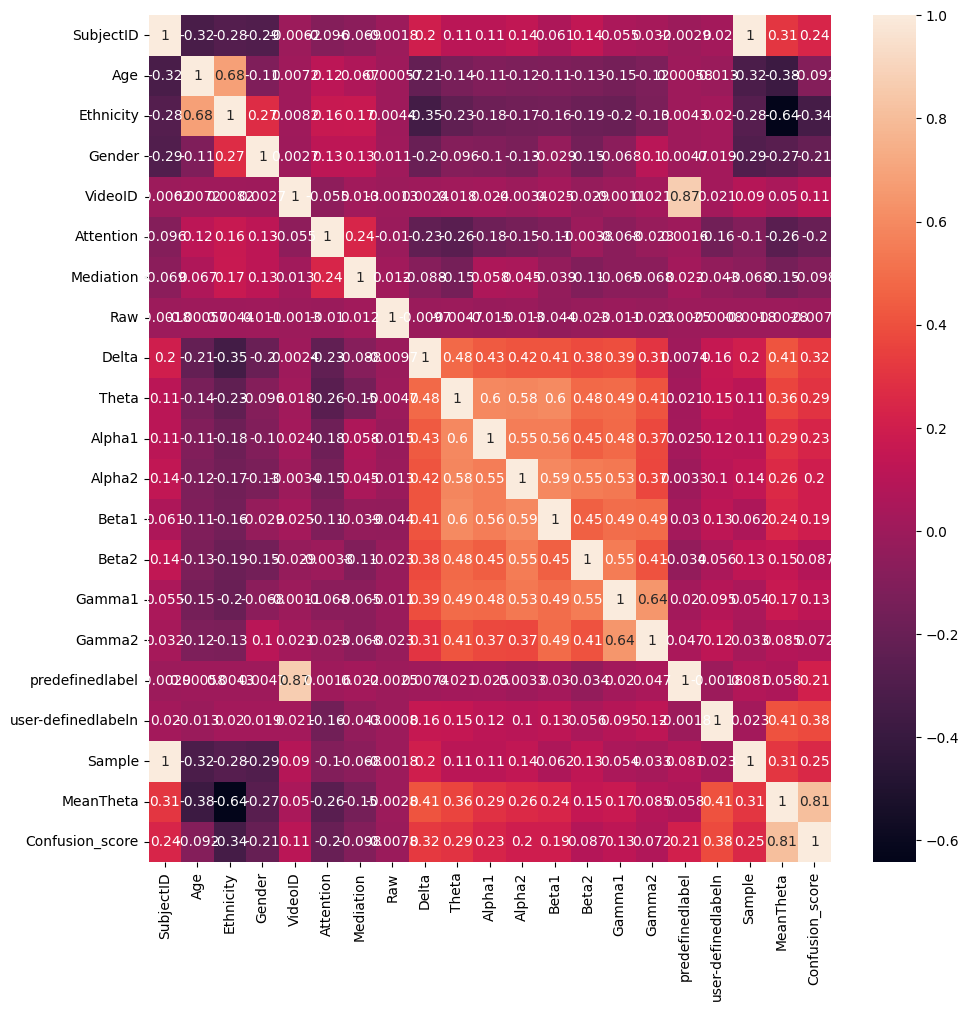

In [58]:
plt.figure(figsize = (11,11))
corr_matrix = eeg_data_info.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show

# Data Modeling

## Random forest classifier model

In [38]:
# Define columns to keep
columns_to_keep = ['MeanTheta', 'Delta', 'Theta']

In [39]:
# Split the data into features (X) and target variable (y)
X = eeg_data_info.drop(eeg_data_info.columns.difference(columns_to_keep), axis=1)
y = eeg_data_info['Confusion_score']

In [40]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [41]:
# Apply SMOTE for oversampling
oversampler = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

In [42]:
# Define the RandomForestClassifier model
random_forest_model = RandomForestClassifier()

In [43]:
# Train the model
random_forest_model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier()

In [44]:
# Make predictions
random_forest_pred = random_forest_model.predict(X_test)

### Model evaluation

In [45]:
# Evaluate the model
accuracy = accuracy_score(y_test, random_forest_pred)
precision = precision_score(y_test, random_forest_pred)
recall = recall_score(y_test, random_forest_pred)
f1 = f1_score(y_test, random_forest_pred)

print("Random Forest Classifier:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Random Forest Classifier:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


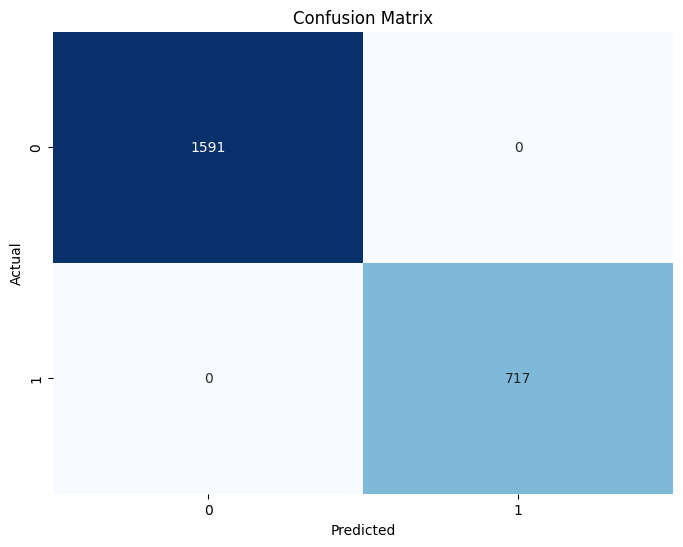

In [46]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, random_forest_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# SVM Model

In [65]:
# Define the SVM model
svm_model = SVC(kernel='linear', C=1.0, random_state=42)

In [66]:
# Train the model
svm_model.fit(X_train_resampled, y_train_resampled)

SVC(kernel='linear', random_state=42)

In [67]:
# Make predictions
svm_pred = svm_model.predict(X_test)

### Model evaluation

In [68]:
# Evaluate the model
accuracy = accuracy_score(y_test, svm_pred)
precision = precision_score(y_test, svm_pred)
recall = recall_score(y_test, svm_pred)
f1 = f1_score(y_test, svm_pred)

print("SVM Classifier:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

SVM Classifier:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


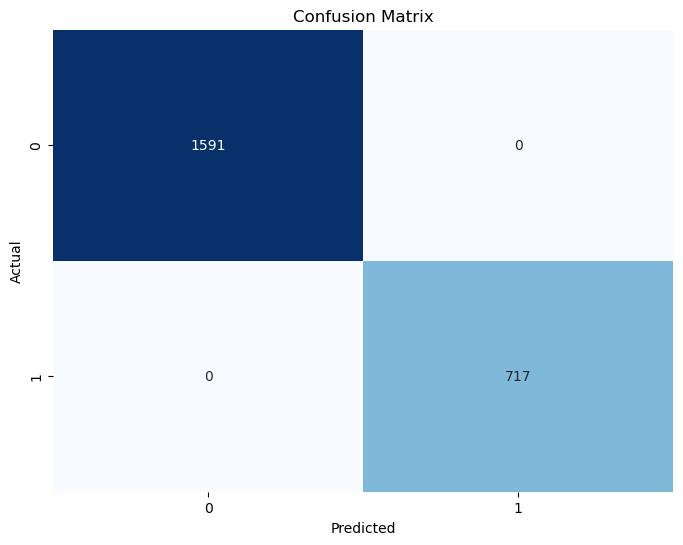

In [ ]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, svm_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# XGBoost classifier Model

In [69]:
# Define the XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

In [70]:
# Train the model
xgb_model.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [71]:
# Make predictions
xgb_pred = xgb_model.predict(X_test)

### Model evaluation

In [72]:
# Evaluate the model
accuracy = accuracy_score(y_test, xgb_pred)
precision = precision_score(y_test, xgb_pred)
recall = recall_score(y_test, xgb_pred)
f1 = f1_score(y_test, xgb_pred)

print("XGBoost Classifier:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

XGBoost Classifier:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


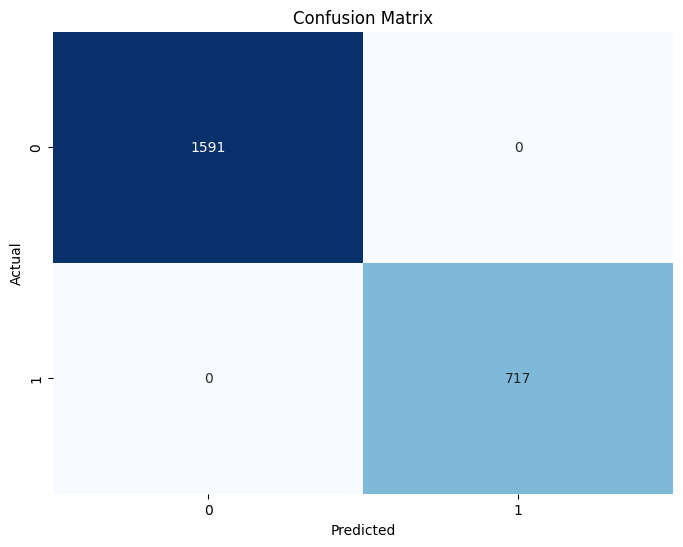

In [73]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, xgb_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# **Linear Regression model**

In [52]:
# Import Linear Regression
from sklearn.linear_model import LinearRegression

# Define the Linear Regression model
linear_regression_model = LinearRegression()

In [53]:
# Train the model
linear_regression_model.fit(X_train_resampled, y_train_resampled)

LinearRegression()

In [54]:
# Make predictions
linear_regression_pred = linear_regression_model.predict(X_test)

In [55]:
# Round predictions to the nearest integer as confusion scores are integers
linear_regression_pred_rounded = np.round(linear_regression_pred)

In [56]:
# Evaluate the model
accuracy = accuracy_score(y_test, linear_regression_pred_rounded)
precision = precision_score(y_test, linear_regression_pred_rounded, average='weighted')
recall = recall_score(y_test, linear_regression_pred_rounded, average='weighted')
f1 = f1_score(y_test, linear_regression_pred_rounded, average='weighted')

print("Linear Regression Model:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Linear Regression Model:
Accuracy: 0.9987
Precision: 0.9987
Recall: 0.9987
F1 Score: 0.9987


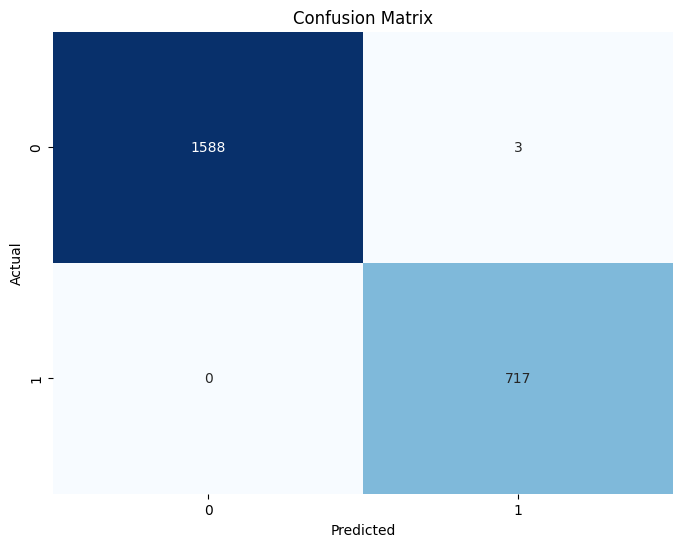

In [57]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, linear_regression_pred_rounded)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()